In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import torch.optim as optim
from PIL import Image
import pandas as pd
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from tqdm import tqdm

In [2]:
zip_path = "/content/train_VGG_AutoAttack-20251201T060942Z-1-001.zip"
extract_dir = "/content/train_VGG_AutoAttack"

import zipfile
import os

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Rozpakowano do:", extract_dir)

Rozpakowano do: /content/train_VGG_AutoAttack


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class AdversarialImageDataset(Dataset):
    """
    This class loads the images from specified folder (save_images generated folder)
    and transforms it to torch dataset for future learning.
    """

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []

        for file in os.listdir(root_dir):
            if file.endswith(".png"):
                self.image_files.append(file)

        self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        path = os.path.join(self.root_dir, img_name)

        image = Image.open(path).convert("RGB")
        label = int(img_name.split("_")[-1].split(".")[0])

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Blok 3
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256*4*4, 512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        # x = self.block5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
from google.colab import drive
drive.mount('/content/drive')

vgg_model_path = "/content/drive/MyDrive/vgg_epoch_80.pth"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
model_vgg = VGG16(num_classes=10)
model_vgg.load_state_dict(torch.load(vgg_model_path, map_location=device))
model_vgg.to(device)

VGG16(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  

In [24]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
BATCH_SIZE = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Combining adversarial datasets
model_name = "VGG"
# attacks_folder = ["AutoAttack"] #["FGSM", "PGD", "CW", "AutoAttack", "DeepFool", "OnePixel"]
list_of_datasets = [trainset]
dataset = AdversarialImageDataset(root_dir="/content/train_VGG_AutoAttack/train_VGG_AutoAttack", transform=transform)
list_of_datasets.append(dataset)

aa_dataset = ConcatDataset(list_of_datasets)
trainloader = DataLoader(aa_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

In [ ]:
num_epochs = 30
best_acc = 50

train_acc_list = []
test_acc_list = []
loss_list = []

for epoch in range(num_epochs):
    model_vgg.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(trainloader, desc=f"Epoka {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100.*correct/total
    epoch_loss = running_loss / len(trainloader)

    model_vgg.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_vgg(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_acc = 100.*correct/total

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    loss_list.append(epoch_loss)

    if test_acc > best_acc:
      best_acc = test_acc
      torch.save(model_vgg.state_dict(), f"VGG_epoch_{epoch+1}.pth")

    scheduler.step()

    print(f"Epoka {epoch+1}/{num_epochs} – Loss: {epoch_loss:.3f} – Train Acc: {train_acc:.2f}% – Test Acc: {test_acc:.2f}%")

Epoka 1/30: 100%|██████████| 782/782 [01:07<00:00, 11.51it/s]


Epoka 1/30 – Loss: 0.448 – Train Acc: 84.83% – Test Acc: 84.72%


Epoka 2/30: 100%|██████████| 782/782 [00:57<00:00, 13.61it/s]


Epoka 2/30 – Loss: 0.308 – Train Acc: 89.24% – Test Acc: 85.27%


Epoka 3/30: 100%|██████████| 782/782 [00:58<00:00, 13.43it/s]


Epoka 3/30 – Loss: 0.262 – Train Acc: 90.83% – Test Acc: 85.45%


Epoka 4/30: 100%|██████████| 782/782 [00:59<00:00, 13.07it/s]


Epoka 4/30 – Loss: 0.232 – Train Acc: 92.03% – Test Acc: 84.87%


Epoka 5/30: 100%|██████████| 782/782 [00:57<00:00, 13.53it/s]


Epoka 5/30 – Loss: 0.209 – Train Acc: 92.76% – Test Acc: 85.65%


Epoka 6/30: 100%|██████████| 782/782 [00:58<00:00, 13.35it/s]


Epoka 6/30 – Loss: 0.195 – Train Acc: 93.24% – Test Acc: 86.03%


Epoka 7/30: 100%|██████████| 782/782 [00:57<00:00, 13.57it/s]


Epoka 7/30 – Loss: 0.184 – Train Acc: 93.60% – Test Acc: 85.77%


Epoka 8/30: 100%|██████████| 782/782 [00:57<00:00, 13.64it/s]


Epoka 8/30 – Loss: 0.176 – Train Acc: 93.97% – Test Acc: 86.87%


Epoka 9/30: 100%|██████████| 782/782 [00:59<00:00, 13.16it/s]


Epoka 9/30 – Loss: 0.163 – Train Acc: 94.43% – Test Acc: 86.98%


Epoka 10/30: 100%|██████████| 782/782 [00:57<00:00, 13.63it/s]


Epoka 10/30 – Loss: 0.157 – Train Acc: 94.61% – Test Acc: 86.71%


Epoka 11/30: 100%|██████████| 782/782 [00:56<00:00, 13.81it/s]


Epoka 11/30 – Loss: 0.151 – Train Acc: 94.80% – Test Acc: 86.96%


Epoka 12/30: 100%|██████████| 782/782 [00:57<00:00, 13.59it/s]


Epoka 12/30 – Loss: 0.146 – Train Acc: 95.03% – Test Acc: 87.38%


Epoka 13/30: 100%|██████████| 782/782 [00:57<00:00, 13.71it/s]


Epoka 13/30 – Loss: 0.141 – Train Acc: 95.22% – Test Acc: 87.24%


Epoka 14/30: 100%|██████████| 782/782 [00:56<00:00, 13.78it/s]


Epoka 14/30 – Loss: 0.138 – Train Acc: 95.24% – Test Acc: 87.31%


Epoka 15/30: 100%|██████████| 782/782 [00:59<00:00, 13.15it/s]


Epoka 15/30 – Loss: 0.134 – Train Acc: 95.44% – Test Acc: 87.44%


Epoka 16/30: 100%|██████████| 782/782 [00:58<00:00, 13.26it/s]


Epoka 16/30 – Loss: 0.128 – Train Acc: 95.61% – Test Acc: 86.80%


Epoka 17/30: 100%|██████████| 782/782 [00:56<00:00, 13.74it/s]


Epoka 17/30 – Loss: 0.128 – Train Acc: 95.51% – Test Acc: 87.31%


Epoka 18/30: 100%|██████████| 782/782 [00:57<00:00, 13.66it/s]


Epoka 18/30 – Loss: 0.124 – Train Acc: 95.70% – Test Acc: 87.73%


Epoka 19/30: 100%|██████████| 782/782 [00:56<00:00, 13.78it/s]


Epoka 19/30 – Loss: 0.120 – Train Acc: 95.83% – Test Acc: 87.71%


Epoka 20/30: 100%|██████████| 782/782 [00:56<00:00, 13.81it/s]


Epoka 20/30 – Loss: 0.119 – Train Acc: 95.93% – Test Acc: 87.03%


Epoka 21/30: 100%|██████████| 782/782 [00:58<00:00, 13.31it/s]


Epoka 21/30 – Loss: 0.114 – Train Acc: 96.04% – Test Acc: 88.22%


Epoka 22/30: 100%|██████████| 782/782 [00:56<00:00, 13.83it/s]


Epoka 22/30 – Loss: 0.113 – Train Acc: 96.13% – Test Acc: 88.20%


Epoka 23/30: 100%|██████████| 782/782 [00:57<00:00, 13.63it/s]


Epoka 23/30 – Loss: 0.109 – Train Acc: 96.35% – Test Acc: 87.62%


Epoka 24/30: 100%|██████████| 782/782 [00:56<00:00, 13.87it/s]


Epoka 24/30 – Loss: 0.109 – Train Acc: 96.23% – Test Acc: 87.27%


Epoka 25/30: 100%|██████████| 782/782 [00:55<00:00, 13.99it/s]


Epoka 25/30 – Loss: 0.106 – Train Acc: 96.39% – Test Acc: 87.94%


Epoka 26/30: 100%|██████████| 782/782 [00:59<00:00, 13.18it/s]


Epoka 26/30 – Loss: 0.103 – Train Acc: 96.46% – Test Acc: 87.65%


Epoka 27/30: 100%|██████████| 782/782 [01:00<00:00, 13.03it/s]


Epoka 27/30 – Loss: 0.096 – Train Acc: 96.71% – Test Acc: 87.76%


Epoka 28/30: 100%|██████████| 782/782 [00:55<00:00, 14.01it/s]


Epoka 28/30 – Loss: 0.096 – Train Acc: 96.69% – Test Acc: 87.94%


Epoka 29/30: 100%|██████████| 782/782 [00:55<00:00, 14.14it/s]


Epoka 29/30 – Loss: 0.097 – Train Acc: 96.70% – Test Acc: 88.08%


Epoka 30/30: 100%|██████████| 782/782 [00:55<00:00, 14.19it/s]


Epoka 30/30 – Loss: 0.090 – Train Acc: 96.91% – Test Acc: 88.02%


In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sn
import numpy as np

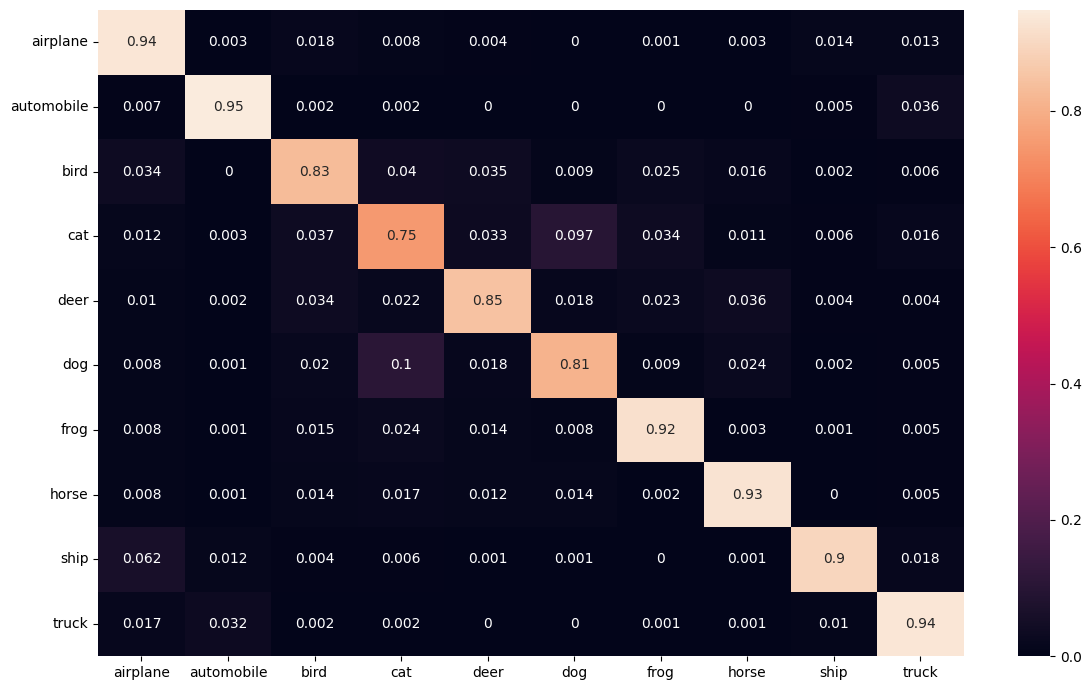

              precision    recall  f1-score   support

    airplane       0.85      0.94      0.89      1000
  automobile       0.95      0.95      0.95      1000
        bird       0.85      0.83      0.84      1000
         cat       0.77      0.75      0.76      1000
        deer       0.88      0.85      0.86      1000
         dog       0.85      0.81      0.83      1000
        frog       0.91      0.92      0.91      1000
       horse       0.91      0.93      0.92      1000
        ship       0.95      0.90      0.92      1000
       truck       0.90      0.94      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [28]:
predicted_labels = []
actual_labels = []
class_names = testset.classes

model_vgg.eval()

with torch.no_grad():
  for images, labels in DataLoader(dataset=testset, batch_size=1):
    images, labels = images.to(device), labels.to(device)
    prediction_logits = model_vgg(images)

    predictions = prediction_logits.argmax(dim=1).cpu().numpy()
    predicted_labels.extend(predictions)
    true_labels = labels.cpu().numpy()
    actual_labels.extend(true_labels)

confusion_mat = confusion_matrix(actual_labels, predicted_labels)
confusion_df = pd.DataFrame(confusion_mat/np.sum(confusion_mat)*10, index=class_names, columns=class_names)

plt.figure(figsize=(12,7))
sn.heatmap(confusion_df, annot=True)
plt.tight_layout()
plt.savefig(f"confusion_matrix_VGG.png")
plt.show()


report = classification_report(actual_labels, predicted_labels, target_names=class_names)
print(report)

with open("confusion_matrix_VGG.txt", "w") as f:
    f.write(report)

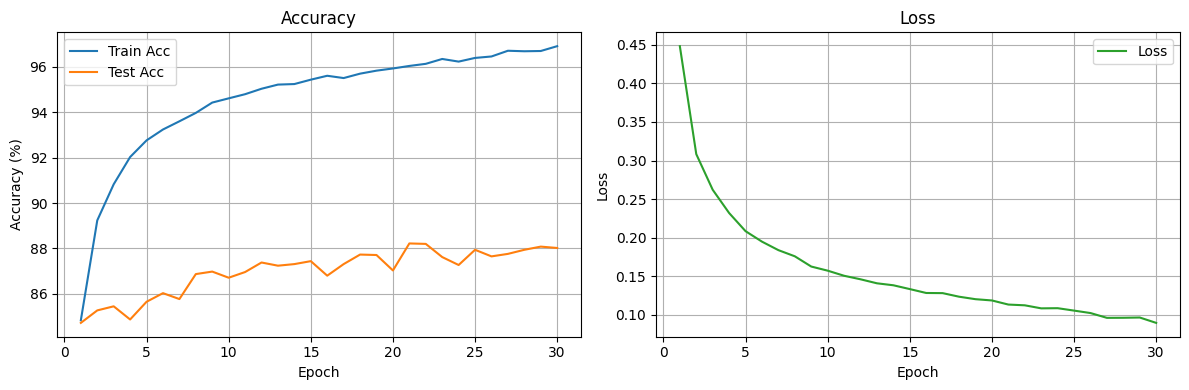

In [29]:
epochs = range(1, len(train_acc_list) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(epochs, train_acc_list, label="Train Acc")
axes[0].plot(epochs, test_acc_list, label="Test Acc")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_title("Accuracy")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, loss_list, label="Loss", color="C2")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("VGG_wykresy.png")
plt.show()